In [9]:
import os
import h2o
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from h2o.automl import H2OAutoML
from h2o.estimators import H2ODeepLearningEstimator, H2OAutoEncoderEstimator
from h2o.frame import H2OFrame

# H2O

## Inicializacion

In [10]:
#h2o.init(ip="172.25.197.59", port=54323)
h2o.init(nthreads=-1, max_mem_size="16G")

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,28 secs
H2O_cluster_timezone:,America/Lima
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 15 days
H2O_cluster_name:,H2O_from_python_giorgio6846_z99ipy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,13.16 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


## Carga de datos

In [11]:
# Prepare data for H2O
smb_dir = (
    "/mnt/sambashare/BigData-DATA/TF"
)
df_h2o = h2o.import_file(os.path.join(smb_dir, "processed", "yellow_tripdata_2016-03_processed.csv"))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Descripcion del dataset entero

In [12]:
df_h2o.describe()

Rows:10886108
Cols:29

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup,dropoff,trip_duration_min,pickup_hour,pickup_dayweek,pickup_daymonth,pickup_hour_cos,pickup_hour_sin,pickup_dayweek_cos,pickup_dayweek_sin,pickup_daymonth_cos,pickup_daymonth_sin
type,int,int,real,real,real,int,enum,real,real,int,real,real,real,real,real,real,real,time,time,int,int,int,int,real,real,real,real,int,real
mins,1.0,0.0,0.0,-161.69866943359375,0.0,1.0,,-161.69866943359375,0.0,1.0,0.0,-58.5,-1.0,0.0,0.0,0.0,0.0,1456790400000.0,1456790400000.0,0.0,0.0,0.0,31.0,-1.0,-1.0,-0.9009688679024191,-0.9749279121818236,1.0,-2.4492935982947064e-16
mean,1.5279851164438245,1.6544614475623483,5.008889724408449,-72.90081106913502,40.158234369721875,1.005863619945716,,-72.95948860661291,40.19228114458139,1.3517295621171492,9.782265755585026,0.33488519588451576,0.49946409864756,1.3254300940244241,0.012480878381878996,0.29995432159960356,12.254480344123019,1458118244281.0024,1458118913838.4788,10.669052796463163,13.714522857939635,2.9789952478884074,31.0,-0.0885505495043517,-0.20898766822094092,-0.05492470953639263,0.05042475838233241,1.0,-2.4492935982947064e-16
maxs,2.0,9.0,19072628.8,0.0,66.85681915283203,99.0,,0.0,50.7978630065918,4.0,28.8,20.0,59.3,27.5,26.54,0.3,28.92,1459468799000.0,1459470676000.0,33.0,23.0,6.0,31.0,1.0,1.0,1.0,0.9749279121818236,1.0,-2.4492935982947064e-16
sigma,0.4992162418739333,1.309840683845017,6340.825049407796,8.870405786074599,4.886184682158715,0.3856325407356842,,8.62000588831496,4.748444324497814,0.4918391119723123,4.638092157457272,0.3746481089580772,0.02491181951942636,1.3091424913814942,0.2721296046822497,0.003698533435901975,5.299094782857815,771684696.4989567,771683969.3962777,6.5089879866852485,6.334782143263285,1.9041309295597628,0.0,0.7015056529855872,0.6755537437326149,0.6935252433907361,0.7165636385930874,0.0,2.0310924969806558e-32
zeros,0,310,51698,158804,158804,0,,149847,149847,0,3231,5438374,11935,4023059,10861917,1652,1155,0,0,74078,376887,1259001,0,0,376887,0,1259001,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,1.0,2.5,-73.97674560546875,40.76515197753906,1.0,N,-74.00426483154297,40.74612808227539,1.0,9.0,0.5,0.5,2.05,0.0,0.3,12.35,2016-03-01 00:00:00,2016-03-01 00:07:55,7.0,0.0,1.0,31.0,1.0,0.0,0.6234898018587336,0.7818314824680298,1.0,-2.4492935982947064e-16
1,1.0,1.0,2.9,-73.98348236083984,40.76792526245117,1.0,N,-74.00594329833984,40.7331657409668,1.0,11.0,0.5,0.5,3.05,0.0,0.3,15.35,2016-03-01 00:00:00,2016-03-01 00:11:06,11.0,0.0,1.0,31.0,1.0,0.0,0.6234898018587336,0.7818314824680298,1.0,-2.4492935982947064e-16
2,2.0,6.0,5.72,-73.99458312988281,40.72784805297851,1.0,N,0.0,0.0,2.0,23.0,0.5,0.5,0.0,0.0,0.3,24.3,2016-03-01 00:00:00,2016-03-01 00:00:00,0.0,0.0,1.0,31.0,1.0,0.0,0.6234898018587336,0.7818314824680298,1.0,-2.4492935982947064e-16


## Seleccion de muestra del dataset

In [13]:
t1, t2 = "trip_duration_min", "fare_amount"

ratio = 500000 / df_h2o.nrows
rand = df_h2o.runif(seed=42)

sampled = df_h2o[rand < ratio]
dataset_small = sampled[0:500000, :]

# EDA

## Descripcion de la muestra del dataset

In [14]:
dataset_small.describe()

Rows:499937
Cols:29

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup,dropoff,trip_duration_min,pickup_hour,pickup_dayweek,pickup_daymonth,pickup_hour_cos,pickup_hour_sin,pickup_dayweek_cos,pickup_dayweek_sin,pickup_daymonth_cos,pickup_daymonth_sin
type,int,int,real,real,real,int,enum,real,real,int,real,real,real,real,real,real,real,time,time,int,int,int,int,real,real,real,real,int,real
mins,1.0,0.0,0.0,-161.69866943359375,0.0,1.0,,-79.48789978027344,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1456790402000.0,1456790570000.0,0.0,0.0,0.0,31.0,-1.0,-1.0,-0.9009688679024191,-0.9749279121818236,1.0,-2.4492935982947064e-16
mean,1.527724493286154,1.6535263443193853,1.952835977333144,-72.88631662090158,40.15027230035291,1.0062287848268878,,-72.94628946704624,40.18508673013822,1.3527764498326786,9.769222962093227,0.334650165920906,0.4994441899679362,1.3206014557834285,0.01241302404102917,0.29995249401424634,12.236284291820759,1458118782810.4895,1458119451491.4858,10.654360449416624,13.717332383880377,2.9803715268123776,31.0,-0.08795247948026629,-0.2087493435586583,-0.05512343004415019,0.0496600473515419,1.0,-2.449293598294707e-16
maxs,2.0,6.0,53.1,0.0,59.1024055480957,99.0,,0.0,45.9057731628418,4.0,28.8,3.0,3.0,21.0,21.0,0.3,28.9,1459468798000.0,1459470262000.0,33.0,23.0,6.0,31.0,1.0,1.0,1.0,0.9749279121818236,1.0,-2.4492935982947064e-16
sigma,0.49923126003741214,1.3089799273878129,1.432412119824293,8.92934247901997,4.918482549893719,0.43578149918740505,,8.673888880722844,4.778394517565888,0.4926332523290992,4.62631360502262,0.3738385560045669,0.01744062638181898,1.304486217208045,0.26925023583442104,0.0037643269313124453,5.286028934114396,771466175.3352581,771465705.1754731,6.503717593939787,6.335415588982986,1.9045296157887817,0.0,0.7013894119775881,0.6758275396148611,0.6936713426306155,0.7164616841223593,0.0,3.0753334462461316e-32
zeros,0,12,2415,7391,7391,0,,6970,6970,0,140,249728,562,185166,498827,78,55,0,0,3379,17239,57909,0,0,17239,0,57909,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,2.0,1.0,2.1,-73.97608947753906,40.75217056274414,1.0,N,-73.9874496459961,40.770782470703125,1.0,9.0,0.5,0.5,2.06,0.0,0.3,12.36,2016-03-01 00:00:02,2016-03-01 00:09:32,9.0,0.0,1.0,31.0,1.0,0.0,0.6234898018587336,0.7818314824680298,1.0,-2.4492935982947064e-16
1,2.0,2.0,0.49,-73.9898681640625,40.757118225097656,1.0,N,-73.98538970947266,40.76319122314453,2.0,4.0,0.5,0.5,0.0,0.0,0.3,5.3,2016-03-01 00:00:05,2016-03-01 00:02:50,2.0,0.0,1.0,31.0,1.0,0.0,0.6234898018587336,0.7818314824680298,1.0,-2.4492935982947064e-16
2,2.0,1.0,2.82,-73.97879028320312,40.76246643066406,1.0,N,-73.98910522460938,40.730716705322266,1.0,11.5,0.5,0.5,3.2,0.0,0.3,16.0,2016-03-01 00:00:17,2016-03-01 00:13:03,12.0,0.0,1.0,31.0,1.0,0.0,0.6234898018587336,0.7818314824680298,1.0,-2.4492935982947064e-16


## Conversion de tablas categoricas

In [15]:
for col in ['store_and_fwd_flag', 'payment_type', 'VendorID']:
    df_h2o[col] = df_h2o[col].asfactor()

### Features comunes de los dos modelos

In [16]:
FeaturesModeloTiempo = [
    'VendorID', 'RatecodeID',
    'passenger_count', 'trip_distance',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'store_and_fwd_flag',
    "pickup_hour_cos", "pickup_hour_sin",
    "pickup_dayweek_cos", "pickup_dayweek_sin",
]

FeaturesModeloCosto = [
    'VendorID', 'RatecodeID',
    'passenger_count', 'trip_distance',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'store_and_fwd_flag', 'RatecodeID',
    'payment_type',
    "pickup_hour_cos", "pickup_hour_sin",
    "pickup_dayweek_cos", "pickup_dayweek_sin",
]

FeaturesComunes = sorted(set(FeaturesModeloTiempo) & set(FeaturesModeloCosto))
FeaturesUnicasTiempo = sorted(set(FeaturesModeloTiempo) - set(FeaturesComunes))
FeaturesUnicasCosto = sorted(set(FeaturesModeloCosto) - set(FeaturesComunes))

In [17]:
dataset_small[FeaturesComunes].describe()

Rows:499937
Cols:13

,RatecodeID,VendorID,dropoff_latitude,dropoff_longitude,passenger_count,pickup_dayweek_cos,pickup_dayweek_sin,pickup_hour_cos,pickup_hour_sin,pickup_latitude,pickup_longitude,store_and_fwd_flag,trip_distance
type,int,int,real,real,int,real,real,real,real,real,real,enum,real
mins,1.0,1.0,0.0,-79.48789978027344,0.0,-0.9009688679024191,-0.9749279121818236,-1.0,-1.0,0.0,-161.69866943359375,,0.0
mean,1.0062287848268878,1.527724493286154,40.18508673013822,-72.94628946704624,1.6535263443193853,-0.05512343004415019,0.0496600473515419,-0.08795247948026629,-0.2087493435586583,40.15027230035291,-72.88631662090158,,1.952835977333144
maxs,99.0,2.0,45.9057731628418,0.0,6.0,1.0,0.9749279121818236,1.0,1.0,59.1024055480957,0.0,,53.1
sigma,0.43578149918740505,0.49923126003741214,4.778394517565888,8.673888880722844,1.3089799273878129,0.6936713426306155,0.7164616841223593,0.7013894119775881,0.6758275396148611,4.918482549893719,8.92934247901997,,1.432412119824293
zeros,0,0,6970,6970,12,0,57909,0,17239,7391,7391,,2415
missing,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,2.0,40.770782470703125,-73.9874496459961,1.0,0.6234898018587336,0.7818314824680298,1.0,0.0,40.75217056274414,-73.97608947753906,N,2.1
1,1.0,2.0,40.76319122314453,-73.98538970947266,2.0,0.6234898018587336,0.7818314824680298,1.0,0.0,40.757118225097656,-73.9898681640625,N,0.49
2,1.0,2.0,40.730716705322266,-73.98910522460938,1.0,0.6234898018587336,0.7818314824680298,1.0,0.0,40.76246643066406,-73.97879028320312,N,2.82


### Features del modelo de estimacion de tiempo

In [18]:
dataset_small[FeaturesUnicasTiempo].describe()

Rows:499937
Cols:0

StopIteration: 

H2OFrame is empty.

### Features del modelo de estimacion de costo

In [19]:
dataset_small[FeaturesUnicasCosto].describe()

Rows:499937
Cols:1

,payment_type
type,int
mins,1.0
mean,1.3527764498326786
maxs,4.0
sigma,0.4926332523290992
zeros,0
missing,0
0,1.0
1,2.0
2,1.0


## Graficos

### Distribucion de la duracion de viaje

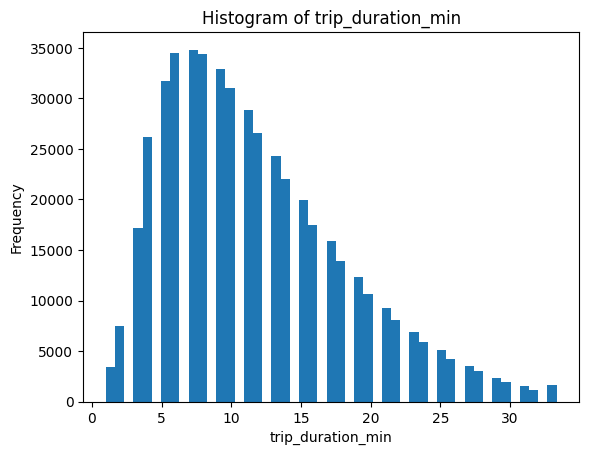

breaks,counts,mids_true,mids,widths
0.66,nan,nan,nan,nan
1.32,3379,0,0.99,0.66
1.98,7447,0.5,1.65,0.66
2.64,0,0,2.31,0.66
3.3,17127,1,2.97,0.66
3.96,26147,1.5,3.63,0.66
4.62,0,0,4.29,0.66
5.28,31711,2,4.95,0.66
5.94,34466,2.5,5.61,0.66
6.6,0,0,6.27,0.66


In [20]:
dataset_small['trip_duration_min'].hist(breaks=50)

### Distribucion del costo total

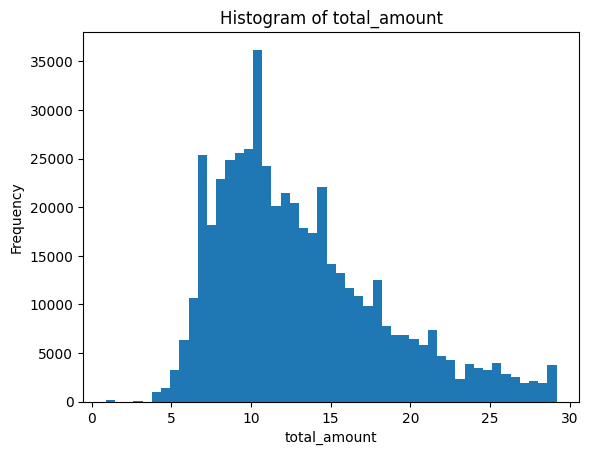

breaks,counts,mids_true,mids,widths
0.578,nan,nan,nan,nan
1.156,167,0.15,0.867,0.578
1.734,7,0.4,1.445,0.578
2.312,3,0.65,2.023,0.578
2.89,23,0.9,2.601,0.578
3.468,6,1.2,3.179,0.578
4.046,936,1.475,3.757,0.578
4.624,1439,1.78,4.335,0.578
5.202,3272,2.05,4.913,0.578
5.78,6353,2.35,5.491,0.578


In [21]:
dataset_small['total_amount'].hist(breaks=50)

### Correlacion de datos de entrenamiento modelo de tiempo

In [22]:
tiempoCorr = dataset_small[FeaturesModeloTiempo].cor().as_data_frame(use_multi_thread=True)
if tiempoCorr.columns[0].lower() in ['correlation','rowname','rownames']:
    tiempoCorr.set_index(tiempoCorr.columns[0], inplace=True)

tiempoCorr = tiempoCorr.astype(float)
mask = np.triu(np.ones(tiempoCorr.shape, dtype=bool))

tiempoCorr

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


,VendorID,RatecodeID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour_cos,pickup_hour_sin,pickup_dayweek_cos,pickup_dayweek_sin
0,1.000000,-0.006715,0.293896,0.018385,-0.057970,0.058031,-0.054129,0.054158,-0.073156,0.002342,-0.005288,0.000361,-0.000751
1,-0.006715,1.000000,-0.005593,-0.000709,0.025125,-0.025112,0.025573,-0.025562,0.021136,0.000837,0.002026,-0.000571,0.000828
2,0.293896,-0.005593,1.000000,0.014631,-0.017149,0.017124,-0.016982,0.016947,-0.021329,0.015253,-0.015919,-0.002474,-0.025761
3,0.018385,-0.000709,0.014631,1.000000,-0.008917,0.008482,-0.018872,0.018944,0.000480,0.155315,0.033868,0.010775,-0.043424
4,-0.057970,0.025125,-0.017149,-0.008917,1.000000,-0.999861,0.876189,-0.876164,0.004526,0.000181,-0.001095,0.000111,-0.002411
5,0.058031,-0.025112,0.017124,0.008482,-0.999861,1.000000,-0.876242,0.876256,-0.004530,-0.001014,0.001230,-0.000059,0.002645
6,-0.054129,0.025573,-0.016982,-0.018872,0.876189,-0.876242,1.000000,-0.999962,0.015316,0.002797,-0.001329,0.000486,-0.002652
7,0.054158,-0.025562,0.016947,0.018944,-0.876164,0.876256,-0.999962,1.000000,-0.015316,-0.003120,0.001299,-0.000424,0.002863
8,-0.073156,0.021136,-0.021329,0.000480,0.004526,-0.004530,0.015316,-0.015316,1.000000,-0.005735,-0.000377,0.005317,0.002422
9,0.002342,0.000837,0.015253,0.155315,0.000181,-0.001014,0.002797,-0.003120,-0.005735,1.000000,-0.199483,-0.035553,-0.059926


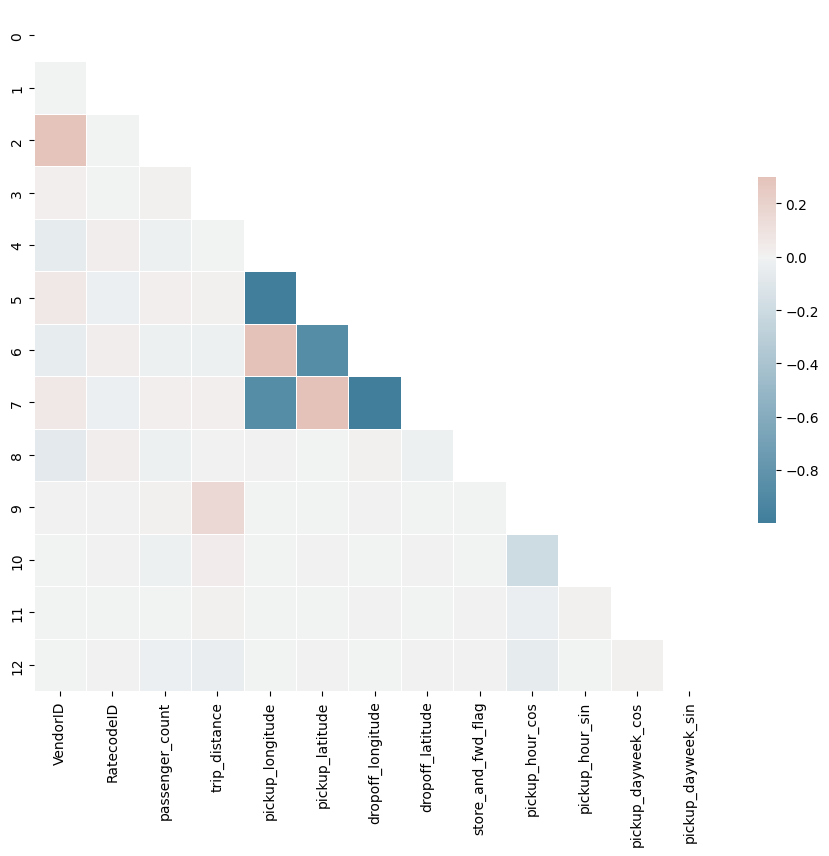

In [23]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(tiempoCorr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()


### Correlacion de datos de entrenamiento modelo de precio

In [24]:
costoCorr = dataset_small[FeaturesModeloCosto].cor().as_data_frame(use_multi_thread=True)
if costoCorr.columns[0].lower() in ['correlation','rowname','rownames']:
    costoCorr.set_index(costoCorr.columns[0], inplace=True)

costoCorr = costoCorr.astype(float)
mask = np.triu(np.ones(costoCorr.shape, dtype=bool))

costoCorr

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


,VendorID,RatecodeID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,RatecodeID0,payment_type,pickup_hour_cos,pickup_hour_sin,pickup_dayweek_cos,pickup_dayweek_sin
0,1.000000,-0.006715,0.293896,0.018385,-0.057970,0.058031,-0.054129,0.054158,-0.073156,-0.006715,-0.018102,0.002342,-0.005288,0.000361,-0.000751
1,-0.006715,1.000000,-0.005593,-0.000709,0.025125,-0.025112,0.025573,-0.025562,0.021136,1.000000,0.012163,0.000837,0.002026,-0.000571,0.000828
2,0.293896,-0.005593,1.000000,0.014631,-0.017149,0.017124,-0.016982,0.016947,-0.021329,-0.005593,0.013699,0.015253,-0.015919,-0.002474,-0.025761
3,0.018385,-0.000709,0.014631,1.000000,-0.008917,0.008482,-0.018872,0.018944,0.000480,-0.000709,-0.042773,0.155315,0.033868,0.010775,-0.043424
4,-0.057970,0.025125,-0.017149,-0.008917,1.000000,-0.999861,0.876189,-0.876164,0.004526,0.025125,0.004242,0.000181,-0.001095,0.000111,-0.002411
5,0.058031,-0.025112,0.017124,0.008482,-0.999861,1.000000,-0.876242,0.876256,-0.004530,-0.025112,-0.003824,-0.001014,0.001230,-0.000059,0.002645
6,-0.054129,0.025573,-0.016982,-0.018872,0.876189,-0.876242,1.000000,-0.999962,0.015316,0.025573,0.016540,0.002797,-0.001329,0.000486,-0.002652
7,0.054158,-0.025562,0.016947,0.018944,-0.876164,0.876256,-0.999962,1.000000,-0.015316,-0.025562,-0.016068,-0.003120,0.001299,-0.000424,0.002863
8,-0.073156,0.021136,-0.021329,0.000480,0.004526,-0.004530,0.015316,-0.015316,1.000000,0.021136,0.013402,-0.005735,-0.000377,0.005317,0.002422
9,-0.006715,1.000000,-0.005593,-0.000709,0.025125,-0.025112,0.025573,-0.025562,0.021136,1.000000,0.012163,0.000837,0.002026,-0.000571,0.000828


<Axes: >

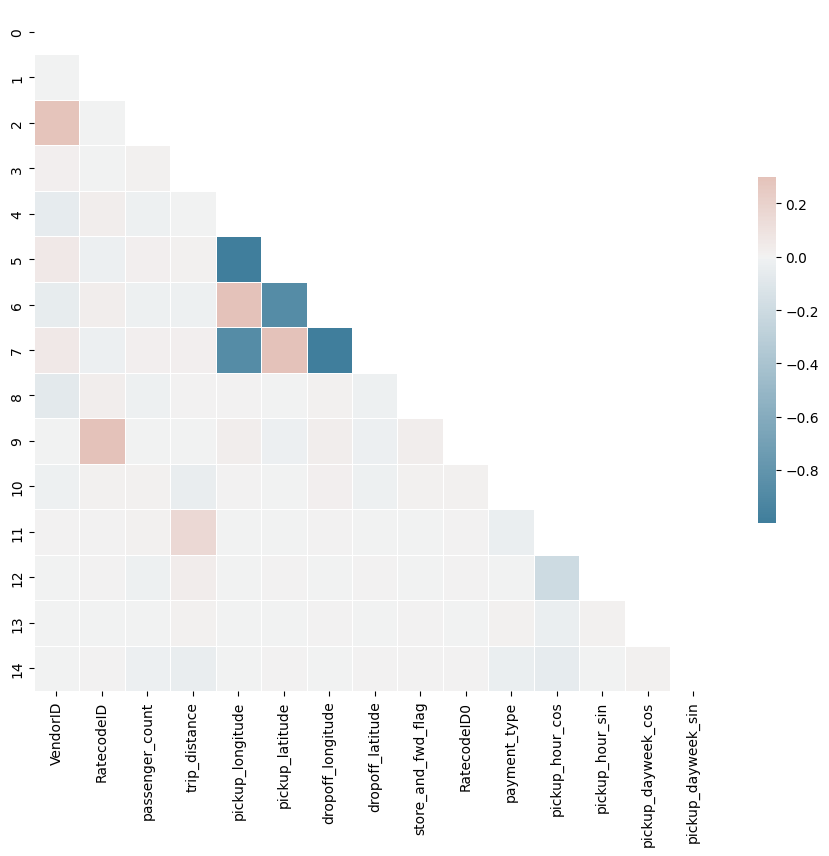

In [25]:
mask = np.triu(np.ones_like(costoCorr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(costoCorr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Entrenamiento

In [26]:
# Targets
target_duration = 'trip_duration_min'
target_fare = 'fare_amount'

# Split data
train, valid = dataset_small.split_frame(ratios=[0.8], seed=42)

# Model 1: Predict trip duration
aml_duration = H2OAutoML(max_models=10, seed=1, nfolds=5)
aml_duration.train(x=FeaturesModeloTiempo, y=target_duration, training_frame=train, validation_frame=valid)
duration_model = aml_duration.leader

# Model 2: Predict fare amount
aml_fare = H2OAutoML(max_models=10, seed=2, nfolds=5)
aml_fare.train(x=FeaturesModeloCosto, y=target_fare, training_frame=train, validation_frame=valid)
fare_model = aml_fare.leader

AutoML progress: |
07:24:08.596: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
07:33:36.47: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%


## Informacion de modelos seleccionados

### Modelo de duracion de viaje

#### Top 10 modelos

In [27]:
aml_duration.leaderboard.head(5)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20250713_72408,2.8263,7.98795,2.01479,nan,7.98795
StackedEnsemble_BestOfFamily_1_AutoML_1_20250713_72408,2.87074,8.24114,2.05343,nan,8.24114
XGBoost_3_AutoML_1_20250713_72408,2.89569,8.38501,2.07718,nan,8.38501
XGBoost_2_AutoML_1_20250713_72408,2.91998,8.52628,2.08944,nan,8.52628
GBM_1_AutoML_1_20250713_72408,2.94562,8.67668,2.11519,nan,8.67668


In [28]:
duration_model

key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/10
# GBM base models (used / total),2/4
# XGBoost base models (used / total),3/3
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


##### Modelo con mejor rendimiento

In [29]:
duration_model.model_id

'StackedEnsemble_AllModels_1_AutoML_1_20250713_72408'

##### Metricas

In [30]:
perf_duration = duration_model.model_performance(valid)
print('Trip Duration RMSE:', perf_duration.rmse())

Trip Duration RMSE: 2.822598910836258


In [31]:
perf_duration

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 7.967064611454031
RMSE: 2.822598910836258
MAE: 2.007799879873729
RMSLE: NaN
Mean Residual Deviance: 7.967064611454031
R^2: 0.8111981596036912
Null degrees of freedom: 99751
Residual degrees of freedom: 99746
Null deviance: 4209352.487044466
Residual deviance: 794730.6291217625
AIC: 490114.84675568034

### Modelo de duracion de precio

#### Top 10 modelos

In [32]:
aml_fare.leaderboard.head(5)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_2_20250713_73336,1.27521,1.62615,0.882148,nan,1.62615
StackedEnsemble_BestOfFamily_1_AutoML_2_20250713_73336,1.29405,1.67457,0.896984,nan,1.67457
XGBoost_3_AutoML_2_20250713_73336,1.31405,1.72673,0.912752,nan,1.72673
GBM_1_AutoML_2_20250713_73336,1.32007,1.74258,0.914986,nan,1.74258
XGBoost_2_AutoML_2_20250713_73336,1.32267,1.74945,0.916964,nan,1.74945


In [33]:
fare_model

key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/10
# GBM base models (used / total),2/4
# XGBoost base models (used / total),3/3
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


##### Modelo con mejor rendimiento

In [34]:
fare_model.model_id

'StackedEnsemble_AllModels_1_AutoML_2_20250713_73336'

##### Metricas

In [35]:
perf_fare = fare_model.model_performance(valid)
print('Fare Amount RMSE:', perf_fare.rmse())

Fare Amount RMSE: 1.278496513207444


In [36]:
perf_fare

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 1.634553334283592
RMSE: 1.278496513207444
MAE: 0.8816408107468126
RMSLE: NaN
Mean Residual Deviance: 1.634553334283592
R^2: 0.9233014714470578
Null degrees of freedom: 99751
Residual degrees of freedom: 99746
Null deviance: 2125856.460630127
Residual deviance: 163049.96420145687
AIC: 332113.011171913